In [1]:
from app import app, db, bcrypt
from models import User, Stock, Portfolio
from flask import jsonify, request
import pandas as pd
import sqlite3

import numpy as np
import statistics

import sys
import json

from datetime import datetime, date, timedelta

from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import io
import base64



In [2]:
data = [
  {
    "date": "Sat, 01 Mar 2025 00:00:00 GMT",
    "id": 2,
    "purchase_price": 1600.0,
    "quantity": 10,
    "symbol": "HDFCBANK.NS"
  },
  {
    "date": "Sat, 01 Feb 2025 00:00:00 GMT",
    "id": 3,
    "purchase_price": 2200.0,
    "quantity": 20,
    "symbol": "HINDUNILVR.NS"
  },
  {
    "date": "Tue, 04 Mar 2025 00:00:00 GMT",
    "id": 4,
    "purchase_price": 3500.0,
    "quantity": 30,
    "symbol": "TCS.NS"
  },
  {
    "date": "Fri, 04 Aug 2023 00:00:00 GMT",
    "id": 5,
    "purchase_price": 900.0,
    "quantity": 10,
    "symbol": "BBTC.NS"
  },
  {
    "date": "Sat, 01 Feb 2025 00:00:00 GMT",
    "id": 6,
    "purchase_price": 1200.0,
    "quantity": 20,
    "symbol": "BALKRISIND.NS"
  },
  {
    "date": "Tue, 10 Sep 2019 00:00:00 GMT",
    "id": 12,
    "purchase_price": 1400.0,
    "quantity": 90,
    "symbol": "HDFCBANK.NS"
  },
  {
    "date": "Wed, 19 May 2021 00:00:00 GMT",
    "id": 13,
    "purchase_price": 1500.0,
    "quantity": 30,
    "symbol": "HDFCBANK.NS"
  },
  {
    "date": "Wed, 08 Feb 2023 00:00:00 GMT",
    "id": 14,
    "purchase_price": 1450.0,
    "quantity": 70,
    "symbol": "HDFCBANK.NS"
  },
  {
    "date": "Wed, 08 Feb 2023 00:00:00 GMT",
    "id": 15,
    "purchase_price": 2450.0,
    "quantity": 70,
    "symbol": "HINDUNILVR.NS"
  },
  {
    "date": "Thu, 11 Mar 2021 00:00:00 GMT",
    "id": 16,
    "purchase_price": 2150.0,
    "quantity": 90,
    "symbol": "HINDUNILVR.NS"
  },
  {
    "date": "Wed, 10 Jul 2019 00:00:00 GMT",
    "id": 17,
    "purchase_price": 3000.0,
    "quantity": 60,
    "symbol": "TCS.NS"
  },
  {
    "date": "Tue, 11 Mar 2025 00:00:00 GMT",
    "id": 18,
    "purchase_price": 1400.0,
    "quantity": 40,
    "symbol": "BALKRISIND.NS"
  },
  {
    "date": "Tue, 11 Mar 2025 00:00:00 GMT",
    "id": 19,
    "purchase_price": 1400.0,
    "quantity": 40,
    "symbol": "BALKRISIND.NS"
  }
]


In [3]:


#data_input = sys.argv[1]

# start and end date
startDate = date.today() - timedelta(days=365)
endDate = date.today()

# Factory Pattern for Trade Creation
class Trade:
    def __init__(self, id, symbol, purchase_price, quantity, date):
        self.id = id
        self.symbol = symbol
        self.purchase_price = purchase_price
        self.quantity = quantity
        self.date = datetime.strptime(date, '%a, %d %b %Y %H:%M:%S %Z')

    def __str__(self):
        return f"Trade(symbol={self.symbol}, purchase_price={self.purchase_price})"

    def lastPrice(self):
        return PortfolioValueProvider().get_asset_value(self.symbol,"Close", startDate, endDate)

    def totalValueNew(self):
        return self.quantity * self.lastPrice()


class TradeFactory:
    def create_trade(self, id, symbol, purchase_price, quantity, date):
        return Trade(id, symbol, purchase_price, quantity, date)


# Portfolio Class with Aggregation and API Interaction
class Portfolio:
    def __init__(self):
        self.trades = []
        self.value_provider = PortfolioValueProvider()
        self.net_values = None  # Store the calculated net values
        self.portfolio_status = {}  # Store the portfolio's status for each date

    def add_trade(self, trade):
        self.trades.append(trade)
        self.update_portfolio_status()

    def add_trades(self, trade_data):
        trade_factory = TradeFactory()
        for trade_info in trade_data:
            self.trades.append(trade_factory.create_trade(**trade_info))
        self.update_portfolio_status()

    def calculate_net(self):
        if self.net_values is None:
            net_value = {}
            total_quantity = {}
            average_price = {}
            current_value = {}
            for trade in self.trades:
                if trade.symbol in net_value:
                    net_value[trade.symbol] += trade.quantity * trade.purchase_price
                    total_quantity[trade.symbol] += trade.quantity
                    average_price[trade.symbol] = net_value[trade.symbol] / total_quantity[trade.symbol]
                    current_value[trade.symbol] = total_quantity[trade.symbol] * self.value_provider.get_asset_value(
                        trade.symbol, "Close", startDate, endDate)
                else:
                    net_value[trade.symbol] = trade.quantity * trade.purchase_price
                    total_quantity[trade.symbol] = trade.quantity
                    average_price[trade.symbol] = net_value[trade.symbol] / total_quantity[trade.symbol]
                    current_value[trade.symbol] = total_quantity[trade.symbol] * self.value_provider.get_asset_value(
                        trade.symbol, "Close", startDate, endDate)
            self.net_values = net_value, total_quantity, average_price, current_value

        return self.net_values

    def calculate_current_value(self, currency):
        current_value = {}
        for trade in self.trades:
            currency_converter = 1
            asset_value = self.value_provider.get_asset_value(trade.symbol, "Close", startDate, trade.date)
            if asset_value is not None:
                current_value[trade.symbol] = asset_value * trade.quantity * currency_converter
        return current_value

    def update_portfolio_status(self):
        for trade in self.trades:
            if trade.date not in self.portfolio_status:
                self.portfolio_status[trade.date] = {}

            if trade.symbol not in self.portfolio_status[trade.date]:
                self.portfolio_status[trade.date][trade.symbol] = trade.quantity
            else:
                self.portfolio_status[trade.date][trade.symbol] += trade.quantity

    def get_portfolio_status_by_date(self, date):
        return self.portfolio_status.get(date, {})

    def get_portfolio_status_for_dates(self, dates):
        portfolio_status_for_dates = []

        for date in dates:
            portfolio_status_for_dates.append({
                'date': date,
                'assets_quantity': self.get_portfolio_status_by_date(date)
            })

        return portfolio_status_for_dates

    def calculate_daily_values_oneyear(self, currency):
        daily_values = []
        trade_dates = []
        stock_quantity = {}
        start_dt = startDate
        end_dt = endDate
        delta = timedelta(days=1)

        # store the dates between two dates in a list
        dates_oneyear = []

        while start_dt <= end_dt:
            dates_oneyear.append(start_dt.isoformat())
            start_dt += delta

        sorted_trades = sorted(self.trades, key=lambda trade: trade.date)
        for date in dates_oneyear:
            total_value_for_date = 0
            for trade in sorted_trades:
                if trade.date == date:
                    total_value_for_date += trade.quantity * self.value_provider.get_asset_value(trade.symbol, date)
            daily_values.append(total_value_for_date)

        portfolio_status = self.get_portfolio_status_for_dates(dates_oneyear)

        return portfolio_status, dates_oneyear

    def assets_on_dates_oneyear(self):
        dates_oneyear = []
        start_dt = startDate
        end_dt = endDate
        delta = timedelta(days=1)

        while start_dt <= end_dt:
            dates_oneyear.append(start_dt.isoformat())
            start_dt += delta

        assets_by_date = {}

        trade_dates_set = set(trade.date for trade in self.trades)
        sorted_trades = sorted(self.trades, key=lambda trade: trade.date)

        for date1 in dates_oneyear:
            assets_on_date = {}
            date1_dt = datetime.fromisoformat(date1)  # Convert date1 to datetime object
            for trade in self.trades:
                if trade.date <= date1_dt:
                    if trade.symbol in assets_on_date:
                        assets_on_date[trade.symbol] += trade.quantity
                    else:
                        assets_on_date[trade.symbol] = trade.quantity
            assets_by_date[date1] = assets_on_date

        return assets_by_date

    @staticmethod
    def portfolio_value_for_dates(portfolio_dict, currency):
        stock_data = {}
        value_provider = PortfolioValueProvider()
        #startDate = date.today() - timedelta(days=365)
        #endDate = date.today()

        for date_str, stocks in portfolio_dict.items():
            date_obj = datetime.strptime(date_str, '%Y-%m-%d').date()  # Convert date string to date object
            for stock_name in stocks.keys():
                if stock_name not in stock_data:
                    stock_data[stock_name] = value_provider.get_asset_values(stock_name, "Close", startDate, endDate)

        portfolio_value_by_dates = {}

        for date_str, stocks in portfolio_dict.items():
            # Convert date string to datetime object with time set to midnight
            date_obj = datetime.strptime(date_str, '%Y-%m-%d')
            date_key = date_obj.strftime('%Y-%m-%d %H:%M:%S')  # Format to match stock_history keys
            total_value = 0

            for stock_name, quantity in stocks.items():
                stock_history = stock_data[stock_name]

                if date_key in stock_history:
                    stock_value = stock_history[date_key] * quantity
                    total_value += stock_value

            if total_value > 0:
                portfolio_value_by_dates[date_str] = total_value
        return portfolio_value_by_dates

    def calculate_risk_metrics(self, price_array, portfolio_value):
            risk_metrics = RiskMetrics(price_array, portfolio_value)
            monte_carlo_var_dollar, simulated_returns = risk_metrics.monte_carlo_var()
            return {
                "mean": risk_metrics.mean(),
                "variance": risk_metrics.variance(),
                "std_dev": risk_metrics.standard_deviation(),
                "max": risk_metrics.max_price(),
                "min": risk_metrics.min_price(),
                "sharpe_ratio": risk_metrics.sharpe_ratio(),
                "sortino_ratio": risk_metrics.sortino_ratio(),
                "value_at_risk": risk_metrics.value_at_risk(),
                "value_at_risk_dollar": risk_metrics.value_at_risk_dollar(),
                "monte_carlo_var": monte_carlo_var_dollar,
                "monte_carlo_simulated_returns": simulated_returns.tolist(),  # For histogram
                "rolling_std_dev": risk_metrics.rolling_std_dev()  # For volatility chart
            }





# Data Collection
class PortfolioValueProvider:
    def __init__(self):
        self.conn = sqlite3.connect('stock_data.db')
        self.cursor = self.conn.cursor()


    def get_asset_value(self, symbol, metric, startDate, endDate):
        query = """
        SELECT d.value
        FROM Data d
        JOIN Companies c ON d.Company_ID = c.Company_ID
        JOIN Metrics m ON d.Metric_ID = m.Metric_ID
        WHERE c.company = ?
        AND m.metric = ?
        AND d.Date BETWEEN ? AND ?
        ORDER BY date DESC LIMIT 1
        """
        self.cursor.execute(query, (symbol, metric, startDate, endDate))
        result = self.cursor.fetchone()
        return result[0] if result else None

    def get_asset_values(self, symbol, metric, startDate, endDate):
        query = """
        SELECT d.Date, d.value
        FROM Data d
        JOIN Companies c ON d.Company_ID = c.Company_ID
        JOIN Metrics m ON d.Metric_ID = m.Metric_ID
        WHERE c.company = ?
        AND m.metric = ?
        AND d.Date BETWEEN ? AND ?
        ORDER BY d.date
        """
        self.cursor.execute(query, (symbol, metric, startDate, endDate))
        result = self.cursor.fetchall()
        return {row[0]: row[1] for row in result}  # Return a dictionary with dates as keys
        #return result
    #{row[0]: row[1] for row in result}

    @staticmethod
    def get_exchange_rate(country, target_currency='USD'):
        if country in PortfolioValueProvider.exchange_rates and target_currency in PortfolioValueProvider.exchange_rates[
            country]:
            return PortfolioValueProvider.exchange_rates[country][target_currency]
        else:
            return 1.0

    # Sample exchange rates (USD to other currencies)
    exchange_rates = {
        'USA': {
            'USD': 1.0,  # 1 USD to USD
            'INR': 75.0,  # Sample exchange rate: 1 USD to 75 INR
            'EUR': 0.85,  # Sample exchange rate: 1 USD to 0.85 EUR
        },
        'India': {
            'INR': 1.0,  # 1 INR to INR
            'USD': 0.013,  # Sample exchange rate: 1 INR to 0.013 USD
            'EUR': 0.011,  # Sample exchange rate: 1 INR to 0.011 EUR
        }
    }

# RiskMetrics Class for Financial Metrics
class RiskMetrics:
    def __init__(self, price_array, portfolio_value, risk_free_rate=0.02):
        self.price_array = price_array
        self.portfolio_value = portfolio_value  # Total portfolio value in dollars
        self.risk_free_rate = risk_free_rate

    def mean(self):
        return np.mean(self.price_array) if self.price_array else 0

    def variance(self):
        return np.var(self.price_array) if self.price_array else 0

    def standard_deviation(self):
        return np.std(self.price_array) if self.price_array else 0

    def max_price(self):
        return max(self.price_array) if self.price_array else 0

    def min_price(self):
        return min(self.price_array) if self.price_array else 0

    def sharpe_ratio(self):
        if not self.price_array or len(self.price_array) < 2:
            return 0
        returns = np.diff(self.price_array) / self.price_array[:-1]  # Daily returns
        excess_returns = returns - self.risk_free_rate
        return np.mean(excess_returns) / np.std(excess_returns) if np.std(excess_returns) != 0 else 0

    def sortino_ratio(self):
        if not self.price_array or len(self.price_array) < 2:
            return 0
        returns = np.diff(self.price_array) / self.price_array[:-1]  # Daily returns
        downside_returns = [r for r in returns if r < 0]
        if len(downside_returns) == 0:
            return 0
        excess_returns = returns - self.risk_free_rate
        return np.mean(excess_returns) / np.std(downside_returns)

    def value_at_risk(self, confidence_level=0.95):
        if not self.price_array or len(self.price_array) < 2:
            return 0
        returns = np.diff(self.price_array) / self.price_array[:-1]  # Daily returns
        return np.percentile(returns, (1 - confidence_level) * 100)
    
    def value_at_risk_dollar(self, confidence_level=0.95):
        # Calculate percentage VaR
        percentage_var = self.value_at_risk(confidence_level)
        # Convert to dollar value VaR
        return self.portfolio_value * percentage_var if self.portfolio_value else 0
    
    def monte_carlo_var(self, num_simulations=1000, confidence_level=0.95):
        """
        Calculate Value at Risk (VaR) using Monte Carlo simulations.
        """
        if not self.price_array or len(self.price_array) < 2:
            return 0

        # Calculate daily returns
        returns = np.diff(self.price_array) / self.price_array[:-1]

        # Fit a normal distribution to the historical returns
        mean_return = np.mean(returns)
        std_dev_return = np.std(returns)

        # Simulate portfolio returns for the given number of scenarios
        simulated_returns = np.random.normal(mean_return, std_dev_return, num_simulations)

        # Calculate the percentile for the confidence level
        var_percentile = np.percentile(simulated_returns, (1 - confidence_level) * 100)
        var_dollar = self.portfolio_value * var_percentile if self.portfolio_value else 0

        return var_dollar, simulated_returns  # Return both VaR and simulated returns

    def rolling_std_dev(self, window=30):
        if not self.price_array or len(self.price_array) < 2:
            return []
        returns = np.diff(self.price_array) / self.price_array[:-1]
        rolling_std = np.lib.stride_tricks.sliding_window_view(returns, window).std(axis=1)
        return rolling_std.tolist()  # Convert to list for JSON serialization
    

# Output
class PortfolioOutput:
    def __init__(self, portfolio, currency):
        self.portfolio = portfolio
        self.currency = currency
        self.optimizer = PortfolioOptimizer(self)  # Add optimizer instance

    def portfolio_daily_value(self):
        return self.portfolio.calculate_current_value(self.currency)

    def portfolio_net_cost(self):
        return self.portfolio.calculate_net()[0]

    def portfolio_total_quantity(self):
        return self.portfolio.calculate_net()[1]

    def portfolio_net_cost_per_unit(self):
        return self.portfolio.calculate_net()[2]

    def portfolio_net(self):
        return self.portfolio.calculate_net()

    def portfolio_daily_values_oneyear(self):
        return self.portfolio.assets_on_dates_oneyear()

    def portfolio_value_date_rs(self):
        input_dict = self.portfolio_daily_values_oneyear()
        values = self.portfolio.portfolio_value_for_dates(input_dict, "USD")
        return values
    
    def optimize_portfolio(self, method='sharpe', cash_to_invest=0, target_return=None, risk_aversion=1.0):
        return self.optimizer.optimize(method, cash_to_invest, target_return, risk_aversion)


    def portfolio_price_history(self):
        """
        Returns a DataFrame containing the price history of each asset in the portfolio.
        - Index: Dates (from startDate to endDate).
        - Columns: Stock symbols (e.g., 'AAPL', 'GOOG').
        - Values: Closing prices for each stock on each date.
        """
        # Get unique stock symbols from the portfolio
        symbols = list(set(trade.symbol for trade in self.portfolio.trades))

        # Fetch historical data for each symbol
        price_data = {}
        for symbol in symbols:
            # Use PortfolioValueProvider to get historical closing prices
            history = self.portfolio.value_provider.get_asset_values(
                symbol, "Close", startDate, endDate
            )
            if history:
                price_data[symbol] = history

        # Create a unified date range (all dates between startDate and endDate)
        date_range = pd.date_range(start=startDate, end=endDate, freq='D')

        # Initialize an empty DataFrame with the date range as the index
        df = pd.DataFrame(index=date_range)

        # Populate the DataFrame with price data for each symbol
        for symbol, history in price_data.items():
            # Convert history dict to a Series with datetime index
            price_series = pd.Series(history)
            price_series.index = pd.to_datetime(price_series.index)  # Ensure index is datetime
            # Align the series with the full date range, filling missing values with NaN
            df[symbol] = price_series.reindex(date_range)

        # Optionally, forward-fill or interpolate missing values
        df = df.ffill()
        # fillna(method='ffill')  # Forward-fill missing prices obj.ffill()

        return df


# New PortfolioOptimizer Class
class PortfolioOptimizer:
    def __init__(self, portfolio_output):
        self.portfolio_output = portfolio_output
        self.price_history = portfolio_output.portfolio_price_history()
        self.stock_names = list(self.price_history.columns)
        self.stock_quantity = pd.Series(
            self.portfolio_output.portfolio.calculate_net()[1], index=self.stock_names
        )
        self.current_prices = self.price_history.iloc[-1]
        self.current_value = (self.stock_quantity * self.current_prices).sum()
        self.current_weights = (self.stock_quantity * self.current_prices) / self.current_value
        self.returns = self.price_history.pct_change().dropna()
        self.mean_returns = self.returns.mean()
        self.cov_matrix = self.returns.cov()
        self.risk_free_rate = 0.02 / 252  # Daily risk-free rate (2% annualized)

    def portfolio_performance(self, weights):
        portfolio_return = np.dot(weights, self.mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        return portfolio_return, portfolio_std

    def neg_sharpe_ratio(self, weights):
        p_return, p_std = self.portfolio_performance(weights)
        return -(p_return - self.risk_free_rate) / p_std

    def neg_sortino_ratio(self, weights):
        p_return, _ = self.portfolio_performance(weights)
        portfolio_returns = np.dot(self.returns, weights)
        downside_returns = portfolio_returns[portfolio_returns < 0]
        downside_std = np.std(downside_returns) if len(downside_returns) > 0 else 1e-6
        return -(p_return - self.risk_free_rate) / downside_std

    def information_ratio(self, weights, benchmark_returns):
        p_return = np.dot(weights, self.mean_returns)
        portfolio_returns = np.dot(self.returns, weights)
        excess_returns = portfolio_returns - benchmark_returns
        tracking_error = np.std(excess_returns)
        return (p_return - benchmark_returns.mean()) / tracking_error if tracking_error > 0 else 0

    def max_drawdown(self, weights):
        portfolio_returns = pd.Series(np.dot(self.returns, weights), index=self.returns.index)
        cumulative = (1 + portfolio_returns).cumprod()
        peak = cumulative.cummax()
        drawdown = (cumulative - peak) / peak
        return -drawdown.min()  # Negative for minimization

    def cvar(self, weights, confidence_level=0.95):
        portfolio_returns = np.dot(self.returns, weights)
        var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
        cvar = portfolio_returns[portfolio_returns <= var].mean()
        return -cvar  # Negative for minimization

    def hhi(self, weights):
        return np.sum(weights ** 2)

    def optimize(self, method='sharpe', cash_to_invest=0, target_return=None, risk_aversion=1.0):
        num_assets = len(self.stock_names)
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        bounds = tuple((0, 1) for _ in range(num_assets))
        initial_guess = np.array([1.0 / num_assets] * num_assets)

        if method == 'sharpe':
            result = minimize(self.neg_sharpe_ratio, initial_guess, method='SLSQP',
                              bounds=bounds, constraints=constraints)
        elif method == 'min_variance':
            result = minimize(lambda w: self.portfolio_performance(w)[1] ** 2, initial_guess,
                              method='SLSQP', bounds=bounds, constraints=constraints)
        elif method == 'max_return':
            result = minimize(lambda w: -np.dot(w, self.mean_returns), initial_guess,
                              method='SLSQP', bounds=bounds, constraints=constraints)
        elif method == 'sortino':
            result = minimize(self.neg_sortino_ratio, initial_guess, method='SLSQP',
                              bounds=bounds, constraints=constraints)
        elif method == 'information_ratio':
            benchmark_returns = self.returns.mean(axis=1)  # Simple market proxy
            result = minimize(lambda w: -self.information_ratio(w, benchmark_returns), initial_guess,
                              method='SLSQP', bounds=bounds, constraints=constraints)
        elif method == 'max_drawdown':
            result = minimize(self.max_drawdown, initial_guess, method='SLSQP',
                              bounds=bounds, constraints=constraints)
        elif method == 'target_return' and target_return:
            constraints.append({'type': 'eq', 'fun': lambda w: np.dot(w, self.mean_returns) - target_return})
            result = minimize(lambda w: self.portfolio_performance(w)[1] ** 2, initial_guess,
                              method='SLSQP', bounds=bounds, constraints=constraints)
        elif method == 'utility':
            result = minimize(lambda w: -(np.dot(w, self.mean_returns) - 0.5 * risk_aversion * self.portfolio_performance(w)[1] ** 2),
                              initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        elif method == 'cvar':
            result = minimize(self.cvar, initial_guess, method='SLSQP',
                              bounds=bounds, constraints=constraints)
        elif method == 'diversification':
            result = minimize(self.hhi, initial_guess, method='SLSQP',
                              bounds=bounds, constraints=constraints)
        else:
            raise ValueError("Unknown optimization method")

        optimal_weights = result.x
        opt_return, opt_std = self.portfolio_performance(optimal_weights)
        suggested_investment = optimal_weights * cash_to_invest

        # Generate visualizations
        visualizations = self.generate_visualizations(method, optimal_weights, target_return)

        return {
            'optimal_weights': dict(zip(self.stock_names, optimal_weights)),
            'suggested_investment': dict(zip(self.stock_names, suggested_investment)),
            'current_weights': dict(self.current_weights),
            'expected_return': opt_return,
            'risk': opt_std,
            'visualizations': visualizations
        }

    def generate_visualizations(self, method, optimal_weights, target_return=None):
        visualizations = {}

        # Efficient Frontier (for most methods)
        if method in ['sharpe', 'min_variance', 'max_return', 'target_return', 'utility']:
            num_portfolios = 1000
            results = np.zeros((2, num_portfolios))
            weights_record = []
            for i in range(num_portfolios):
                w = np.random.random(len(self.stock_names))
                w /= w.sum()
                weights_record.append(w)
                ret, std = self.portfolio_performance(w)
                results[0, i] = ret
                results[1, i] = std
            curr_ret, curr_std = self.portfolio_performance(self.current_weights)
            opt_ret, opt_std = self.portfolio_performance(optimal_weights)

            plt.figure(figsize=(8, 6))
            plt.scatter(results[1], results[0], c='gray', alpha=0.5)
            plt.scatter(curr_std, curr_ret, c='blue', marker='*', s=200, label='Current Portfolio')
            plt.scatter(opt_std, opt_ret, c='red', marker='*', s=200, label='Optimal Portfolio')
            if target_return:
                plt.axhline(target_return, color='green', linestyle='--', label='Target Return')
            plt.xlabel('Risk (Std Dev)')
            plt.ylabel('Expected Return')
            plt.title(f'Efficient Frontier - {method.capitalize()}')
            plt.legend()
            img = io.BytesIO()
            plt.savefig(img, format='png', bbox_inches='tight')
            img.seek(0)
            visualizations['efficient_frontier'] = f'data:image/png;base64,{base64.b64encode(img.getvalue()).decode("utf8")}'
            plt.close()

        # Pie Chart (all methods)
        plt.figure(figsize=(8, 8))
        plt.pie(optimal_weights, labels=self.stock_names, autopct='%1.1f%%', startangle=90)
        plt.title(f'Optimal Allocation - {method.capitalize()}')
        img = io.BytesIO()
        plt.savefig(img, format='png', bbox_inches='tight')
        img.seek(0)
        visualizations['pie_chart'] = f'data:image/png;base64,{base64.b64encode(img.getvalue()).decode("utf8")}'
        plt.close()

        # Additional visualizations based on method
        if method == 'sortino':
            portfolio_returns = np.dot(self.returns, optimal_weights)
            downside_returns = portfolio_returns[portfolio_returns < 0]
            plt.figure(figsize=(8, 6))
            sns.histplot(downside_returns, bins=30, kde=True)
            plt.title('Downside Returns Distribution')
            plt.xlabel('Returns')
            img = io.BytesIO()
            plt.savefig(img, format='png', bbox_inches='tight')
            img.seek(0)
            visualizations['downside_histogram'] = f'data:image/png;base64,{base64.b64encode(img.getvalue()).decode("utf8")}'
            plt.close()

        if method == 'max_drawdown':
            portfolio_returns = pd.Series(np.dot(self.returns, optimal_weights), index=self.returns.index)
            #portfolio_returns = np.dot(self.returns, optimal_weights)
            cumulative = (1 + portfolio_returns).cumprod()
            drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
            plt.figure(figsize=(8, 6))
            plt.plot(self.returns.index, drawdown, label='Drawdown')
            plt.title('Portfolio Drawdown')
            plt.xlabel('Date')
            plt.ylabel('Drawdown')
            plt.legend()
            img = io.BytesIO()
            plt.savefig(img, format='png', bbox_inches='tight')
            img.seek(0)
            visualizations['drawdown_chart'] = f'data:image/png;base64,{base64.b64encode(img.getvalue()).decode("utf8")}'
            plt.close()

        if method == 'cvar':
            portfolio_returns = np.dot(self.returns, optimal_weights)
            plt.figure(figsize=(8, 6))
            sns.histplot(portfolio_returns, bins=30, kde=True)
            cvar_val = self.cvar(optimal_weights)
            plt.axvline(-cvar_val, color='red', linestyle='--', label='CVaR')
            plt.title('Returns with CVaR')
            plt.xlabel('Returns')
            plt.legend()
            img = io.BytesIO()
            plt.savefig(img, format='png', bbox_inches='tight')
            img.seek(0)
            visualizations['cvar_histogram'] = f'data:image/png;base64,{base64.b64encode(img.getvalue()).decode("utf8")}'
            plt.close()

        return visualizations

# Modify OutputForPHP to include optimization
class OutputForPHP:
    def __init__(self, currency):
        self.output_list = []
        self.portfolio = Portfolio()
        self.currency = currency

    def output_portfolio(self, trade_data):
        self.portfolio.add_trades(trade_data)
        portfolioOutput = PortfolioOutput(self.portfolio, self.currency)
        output = portfolioOutput.portfolio_net()
        output_currentValue = portfolioOutput.portfolio_daily_value()
        output_dailyvalues2 = portfolioOutput.portfolio_value_date_rs()
        output_dailyvalues = portfolioOutput.portfolio_daily_values_oneyear()
        output_pricehistory = portfolioOutput.portfolio_price_history()

        price_array = list(output_dailyvalues2.values())
        portfolio_value = sum(output[3].values()) if output[3].values() else 0
        risk_metrics = self.portfolio.calculate_risk_metrics(price_array, portfolio_value)

        output_list = [
            [
                key,
                [list(output[1].values())[i], list(output[0].values())[i], list(output[2].values())[i],
                 list(output[3].values())[i]]
            ]
            for i, key in enumerate(output[0].keys())
        ]

        # Add optimization results
        optimizations = {}
        methods = ['sharpe', 'min_variance', 'max_return', 'sortino', 'information_ratio',
                   'max_drawdown', 'target_return', 'utility', 'cvar', 'diversification']
        for method in methods:
            kwargs = {'cash_to_invest': 100000}  # Example cash
            if method == 'target_return':
                kwargs['target_return'] = 0.0005  # Daily target return (e.g., ~12.6% annualized)
            if method == 'utility':
                kwargs['risk_aversion'] = 2.0
            optimizations[method] = portfolioOutput.optimize_portfolio(method, **kwargs)

        return {
            "dates": list(output_dailyvalues2.keys()),
            "prices": price_array,
            "risk_metrics": risk_metrics,
            "portfolio_consolidated": output_list,
            "portfolio_purchase_price": list(output[0].values()),
            "portfolio_stock_names": list(output[0].keys()),
            "portfolio_current_value": list(output[3].values()),
            "price_history": output_pricehistory.to_dict(orient='index'),
            "stock_quantity": list(output[1].values()),
            "optimizations": optimizations
        }


def main(dataInput):
    #dataInput = json.loads(data_input)
    output = OutputForPHP("INR").output_portfolio(dataInput)
    return output


In [4]:
main(data)
output = main(data)

{'sharpe': {'optimal_weights': {'HINDUNILVR.NS': np.float64(0.4077096879215304),
   'BBTC.NS': np.float64(0.30433625081437754),
   'BALKRISIND.NS': np.float64(0.10286523563955499),
   'HDFCBANK.NS': np.float64(0.18065199038482788),
   'TCS.NS': np.float64(0.004436835239709294)},
  'suggested_investment': {'HINDUNILVR.NS': np.float64(40770.96879215304),
   'BBTC.NS': np.float64(30433.625081437753),
   'BALKRISIND.NS': np.float64(10286.5235639555),
   'HDFCBANK.NS': np.float64(18065.199038482788),
   'TCS.NS': np.float64(443.6835239709294)},
  'current_weights': {'HINDUNILVR.NS': np.float64(0.30086627271133215),
   'BBTC.NS': np.float64(0.015259720562987697),
   'BALKRISIND.NS': np.float64(0.18720058764595757),
   'HDFCBANK.NS': np.float64(0.23289611969300575),
   'TCS.NS': np.float64(0.26377729938671685)},
  'expected_return': np.float64(0.000543172477659808),
  'risk': np.float64(0.009385322184087186),
  'visualizations': {'efficient_frontier': '',
   'pie_chart': ''}},
 'min_variance'
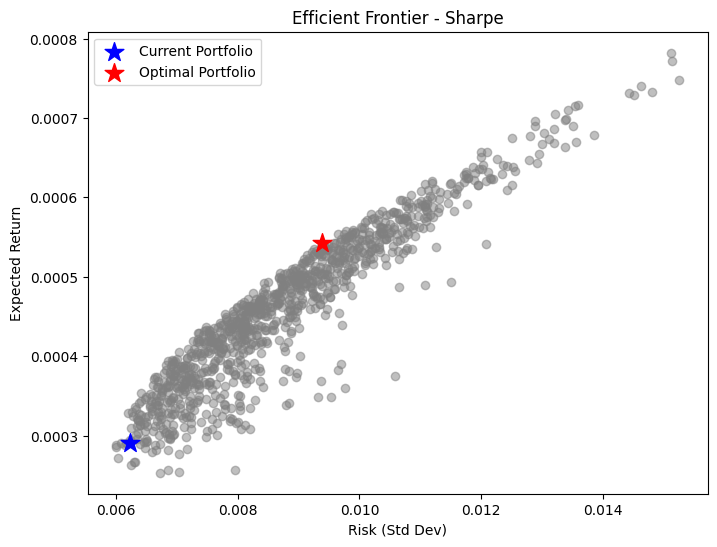
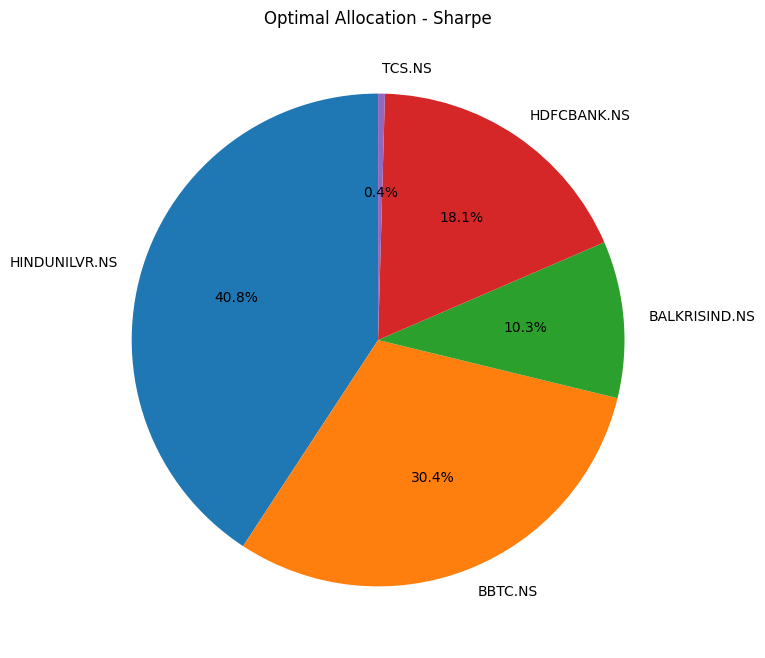
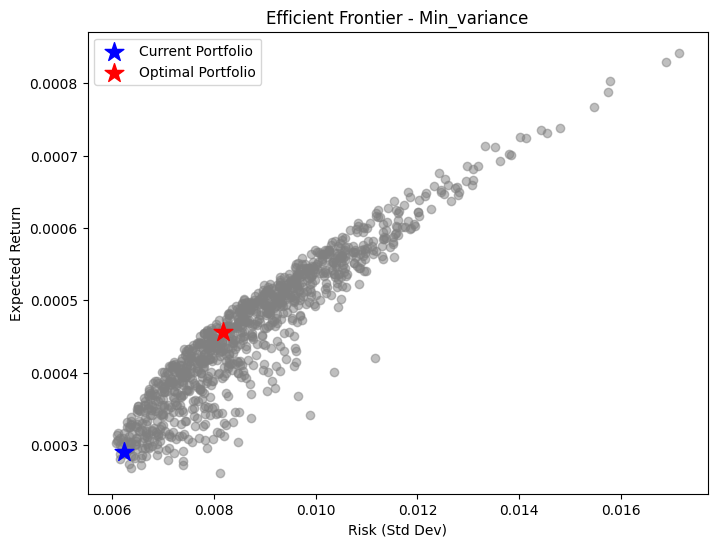
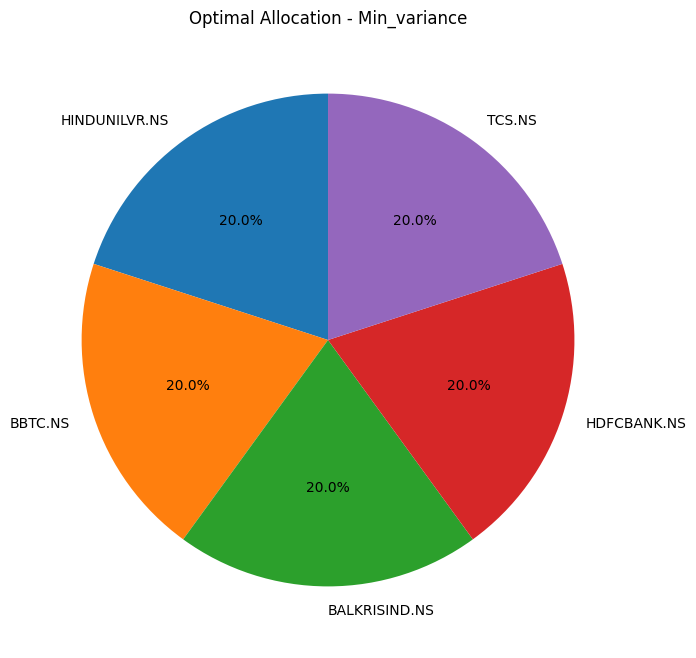
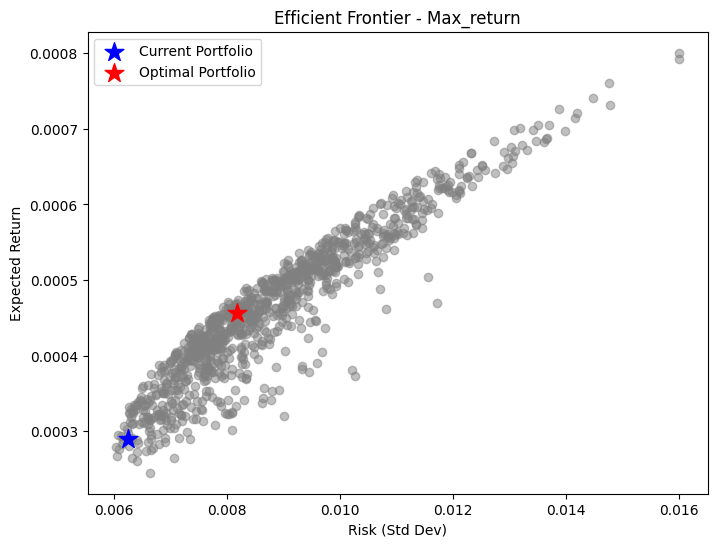
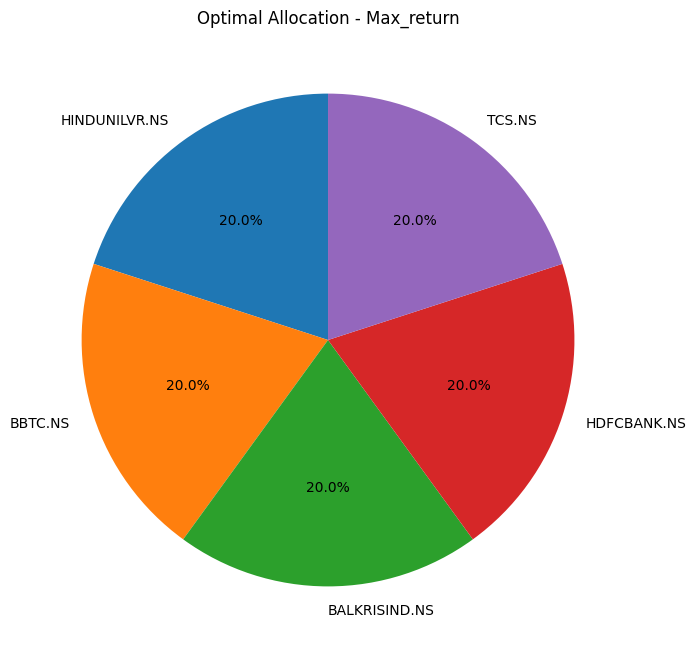
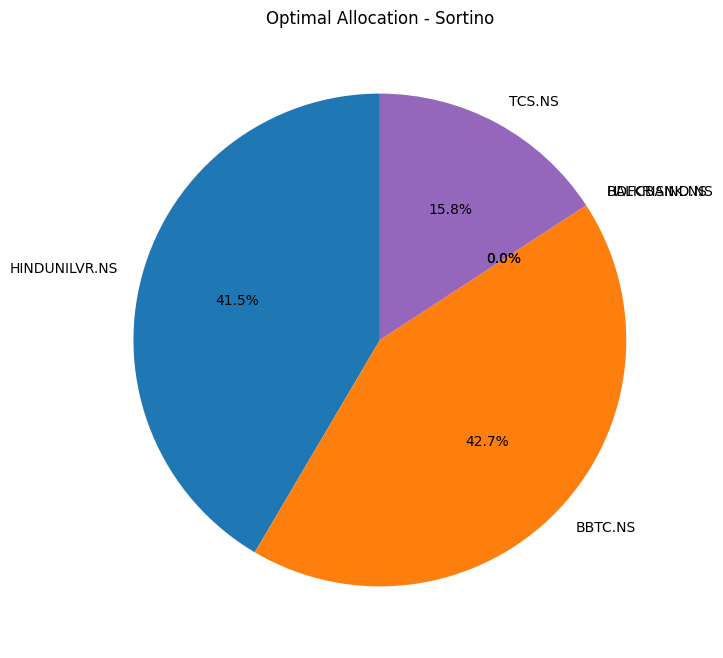
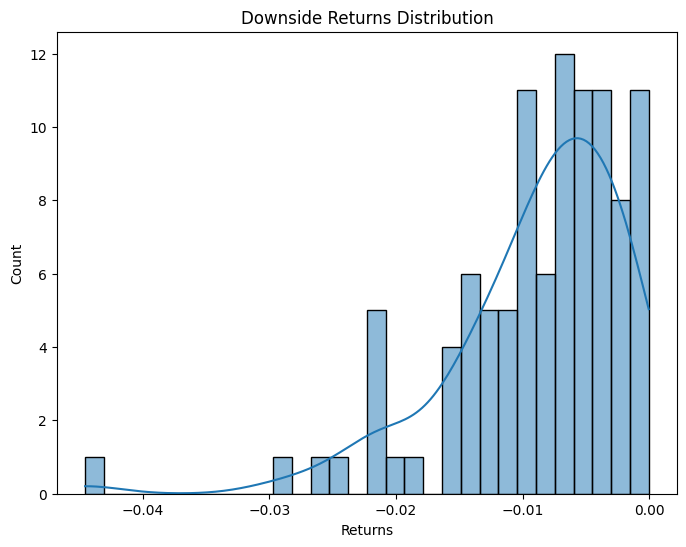
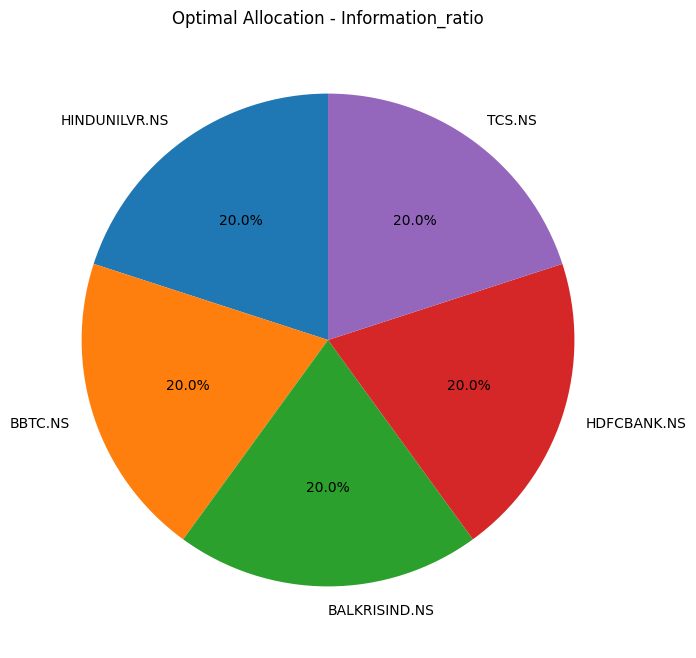
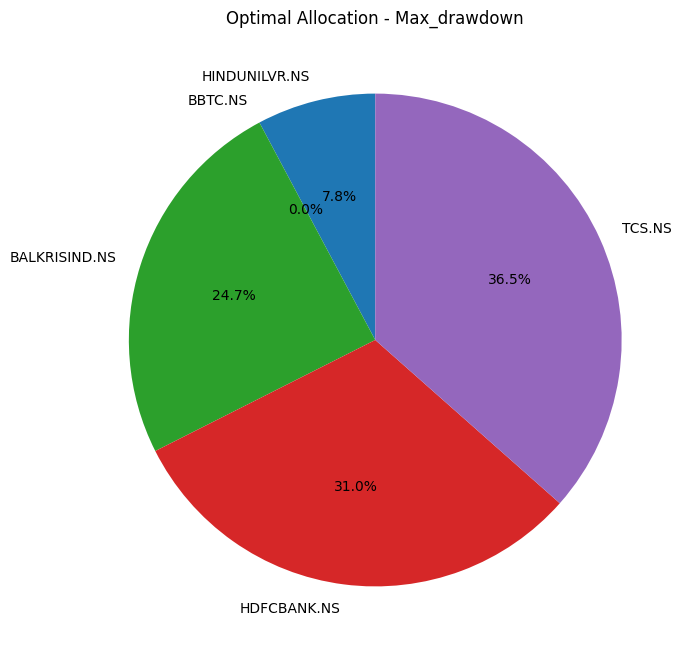
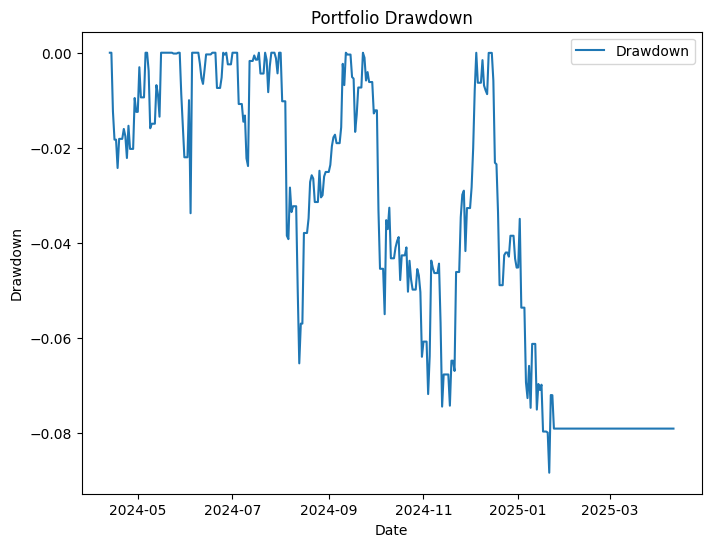
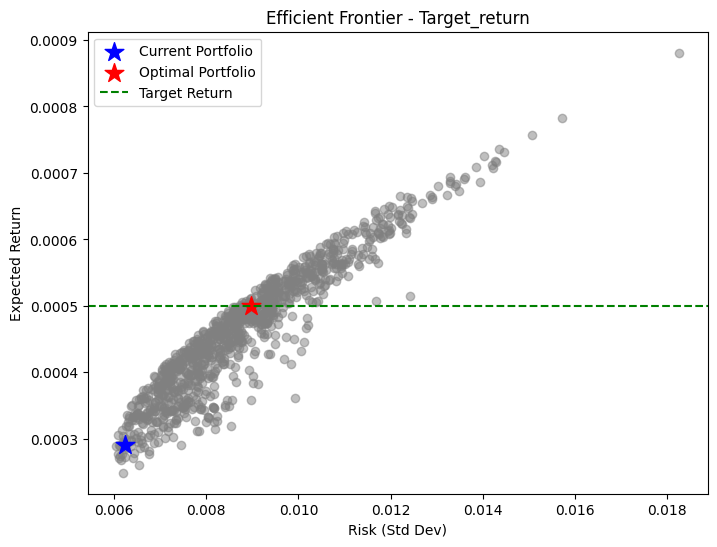
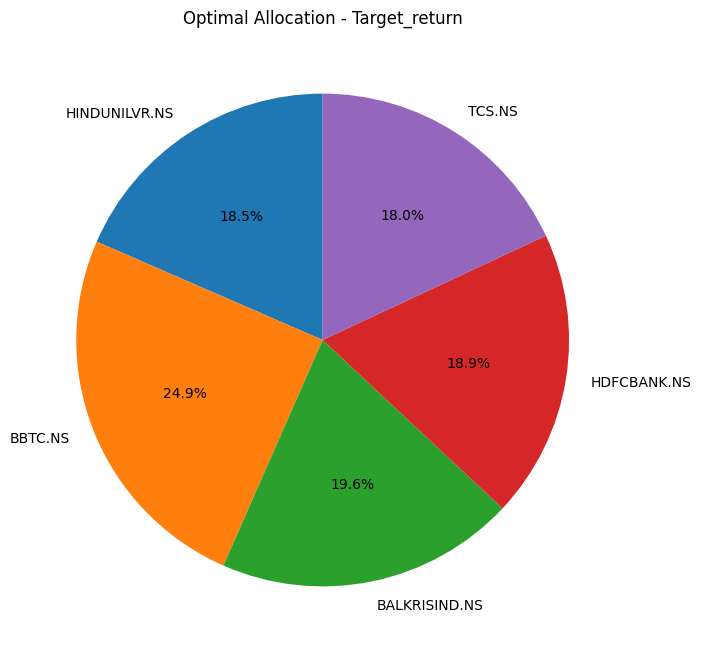
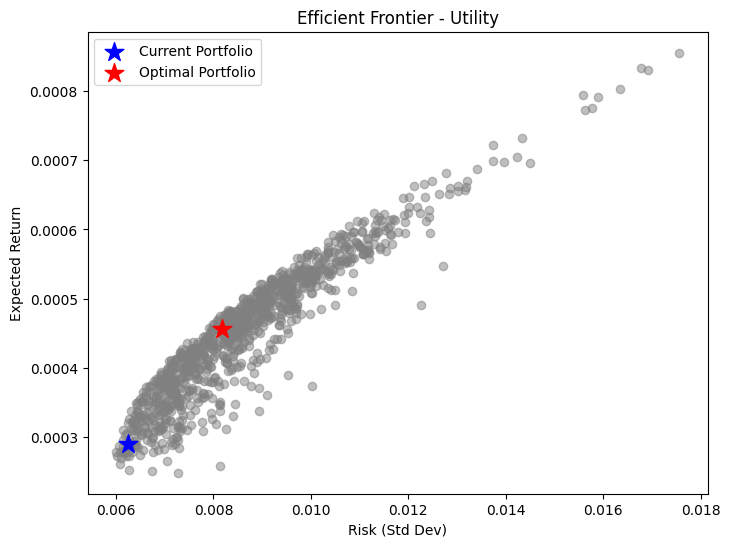
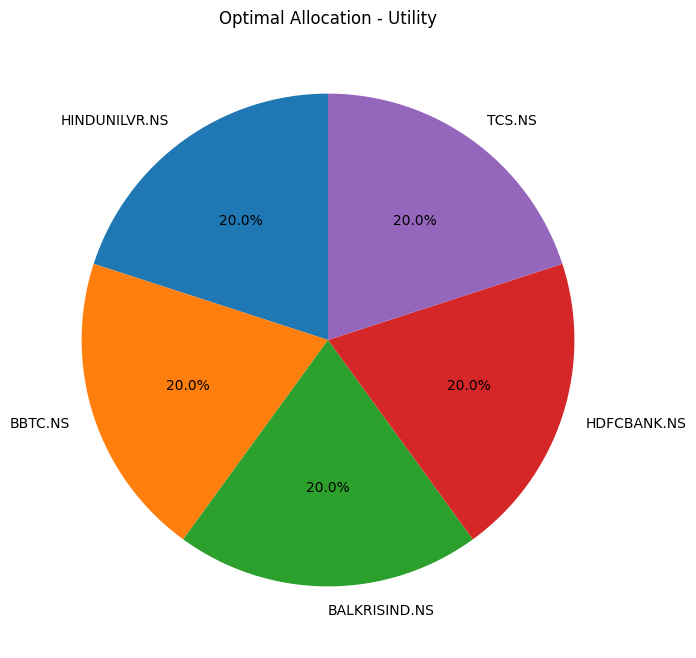
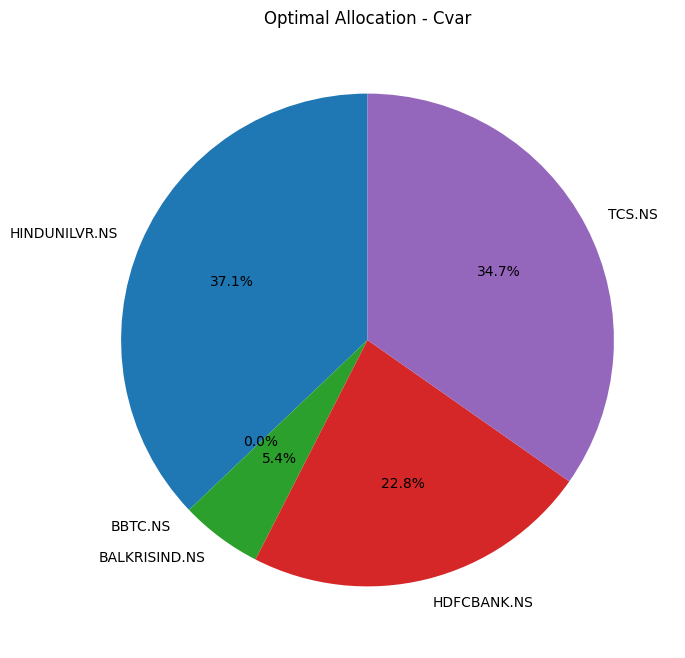
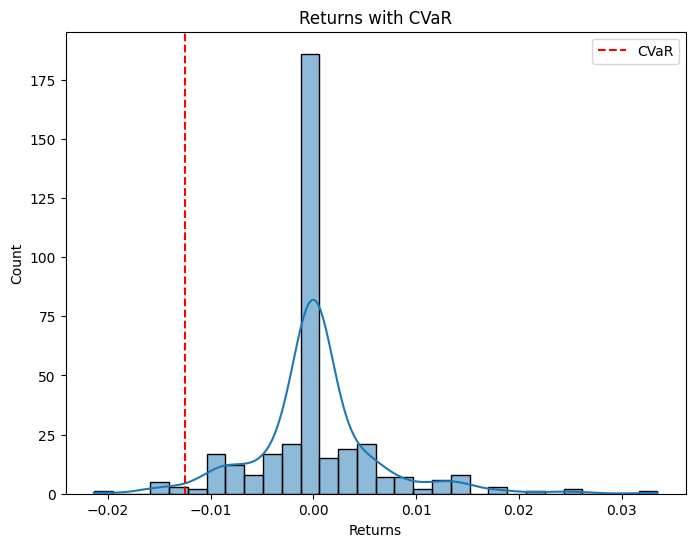
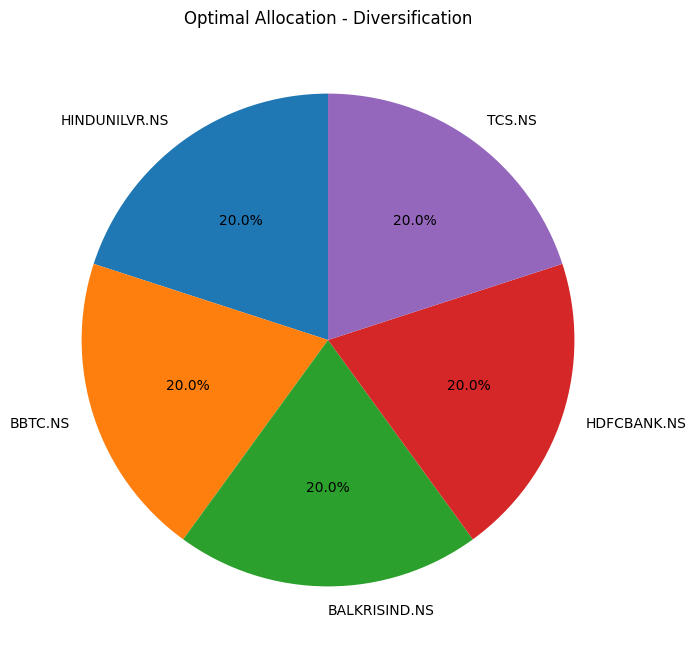

In [5]:
output["optimizations"]

''
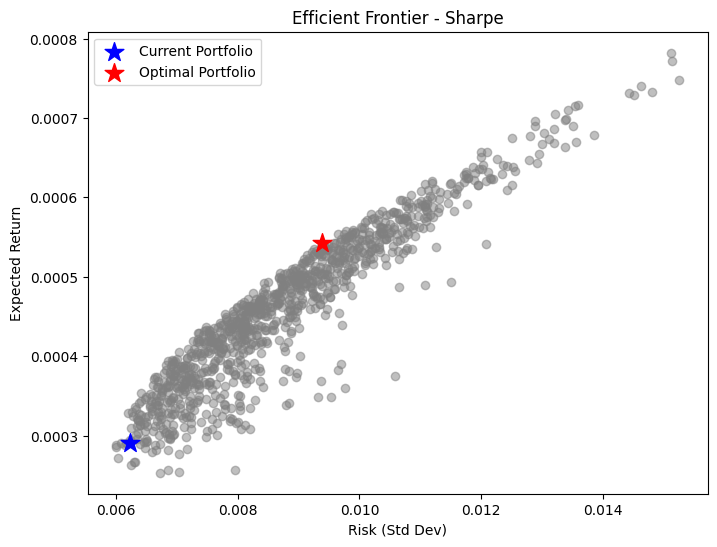

In [6]:
output["optimizations"]["sharpe"]["visualizations"]["efficient_frontier"]

In [7]:
from IPython.display import Image, display

In [8]:
import base64
from io import BytesIO
import matplotlib.pyplot as plt
from IPython.display import display

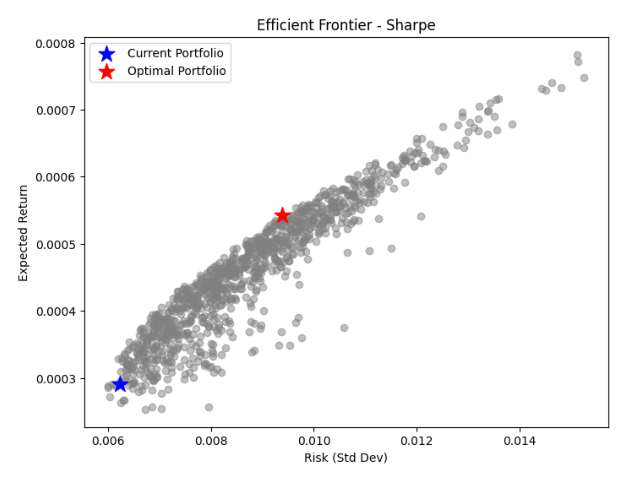

In [9]:
# Select the visualization
base64_string = output["optimizations"]["sharpe"]["visualizations"]["efficient_frontier"]

# Extract the base64 data (remove "data:image/png;base64," prefix)
base64_data = base64_string.split(',')[1]

# Decode base64 to bytes
img_bytes = base64.b64decode(base64_data)

# Load bytes into an image
img = plt.imread(BytesIO(img_bytes), format='png')

# Display using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

{'sharpe': {'optimal_weights': {'HINDUNILVR.NS': np.float64(0.4077096879215304),
   'BBTC.NS': np.float64(0.30433625081437754),
   'BALKRISIND.NS': np.float64(0.10286523563955499),
   'HDFCBANK.NS': np.float64(0.18065199038482788),
   'TCS.NS': np.float64(0.004436835239709294)},
  'suggested_investment': {'HINDUNILVR.NS': np.float64(40770.96879215304),
   'BBTC.NS': np.float64(30433.625081437753),
   'BALKRISIND.NS': np.float64(10286.5235639555),
   'HDFCBANK.NS': np.float64(18065.199038482788),
   'TCS.NS': np.float64(443.6835239709294)},
  'current_weights': {'HINDUNILVR.NS': np.float64(0.30086627271133215),
   'BBTC.NS': np.float64(0.015259720562987697),
   'BALKRISIND.NS': np.float64(0.18720058764595757),
   'HDFCBANK.NS': np.float64(0.23289611969300575),
   'TCS.NS': np.float64(0.26377729938671685)},
  'expected_return': np.float64(0.000543172477659808),
  'risk': np.float64(0.009385322184087186),
  'visualizations': {'efficient_frontier': '',
   'pie_chart': ''}},
 'min_variance'
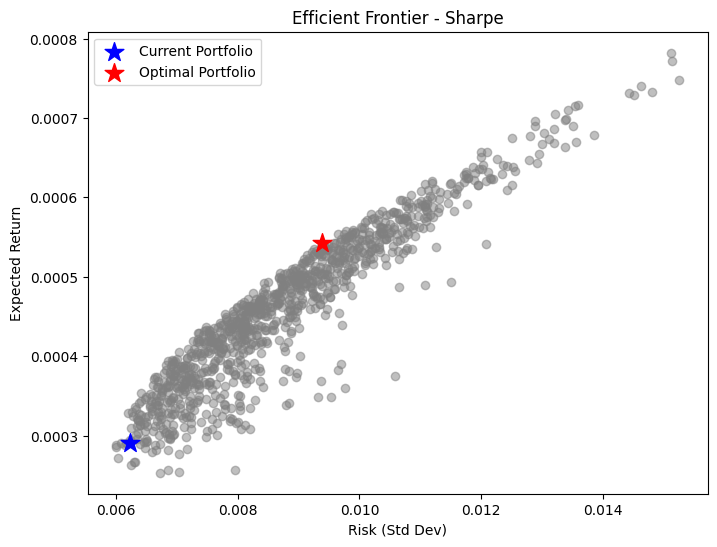
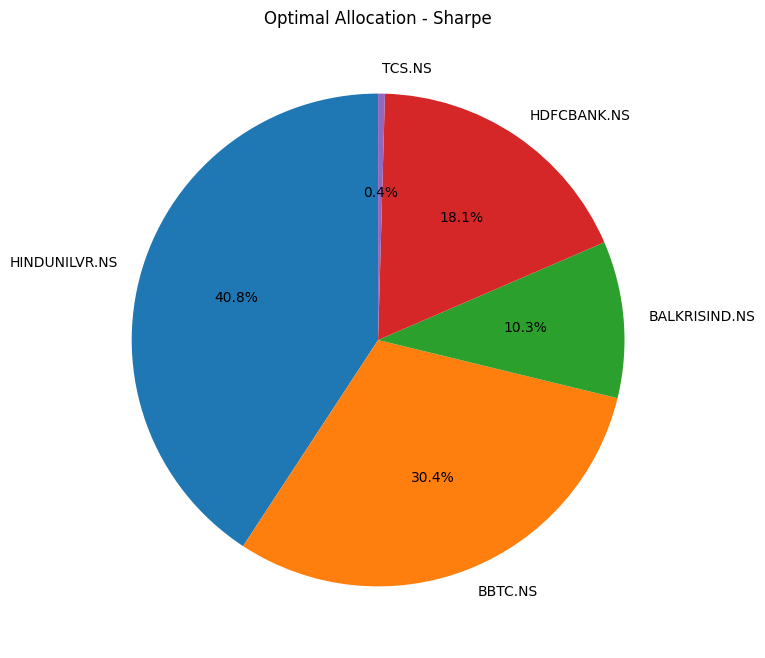
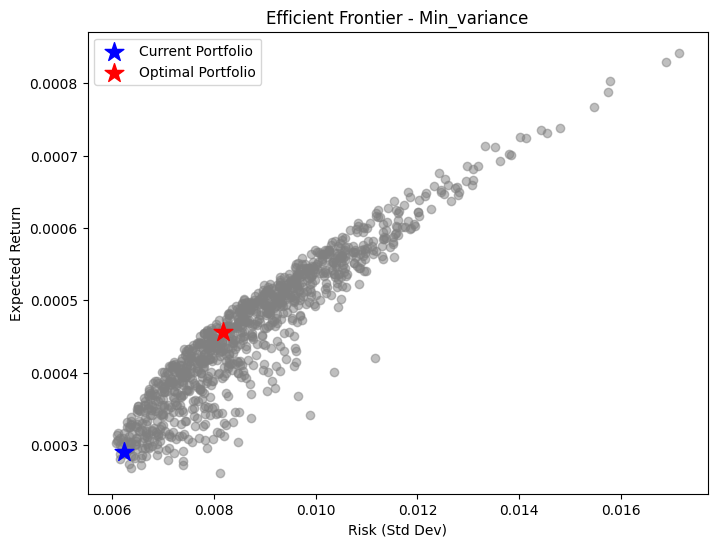
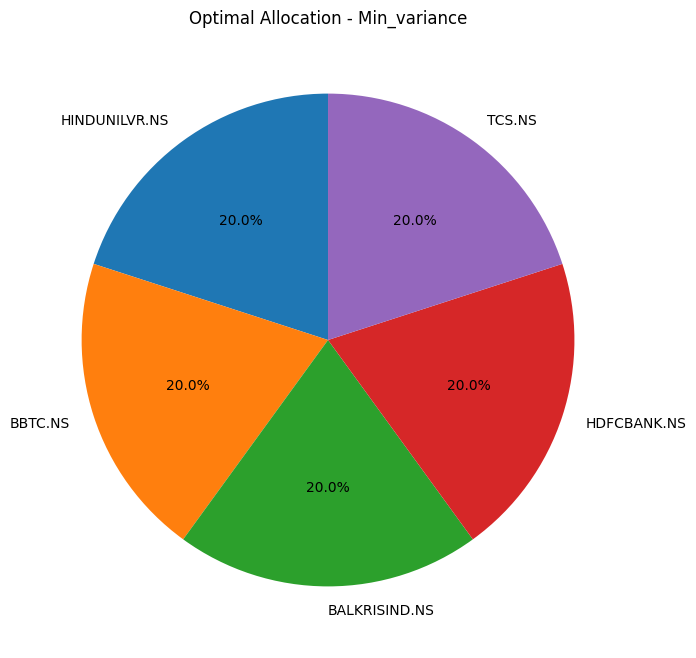
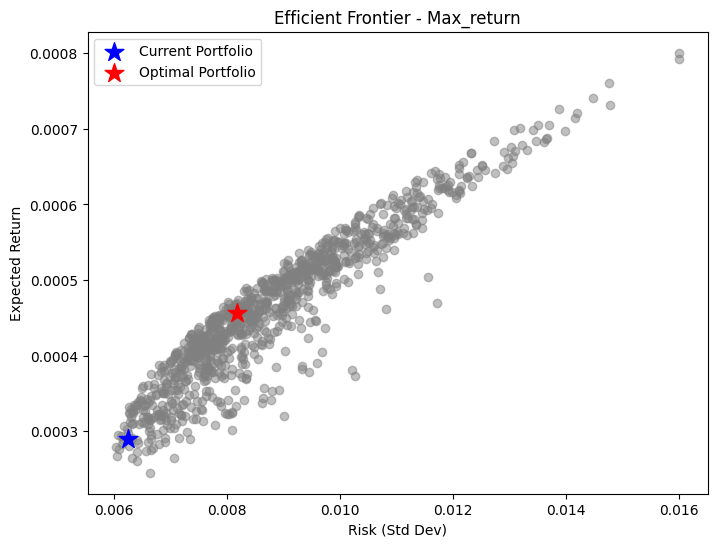
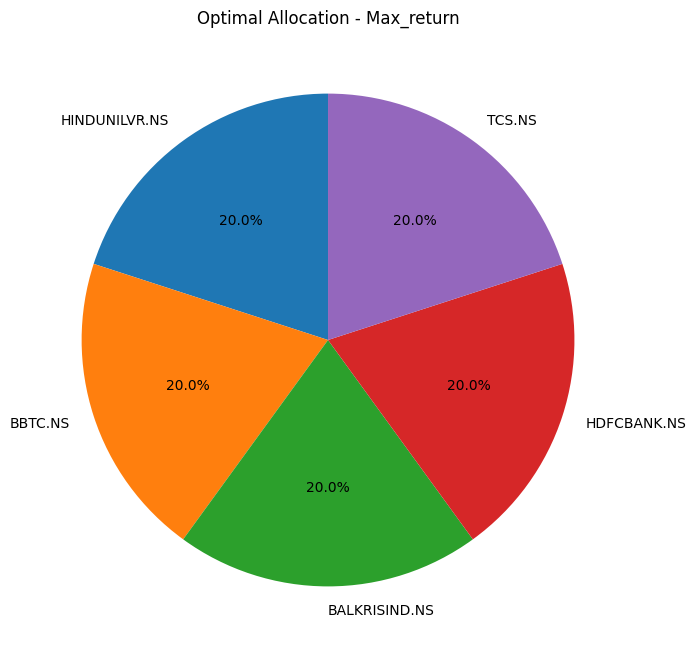
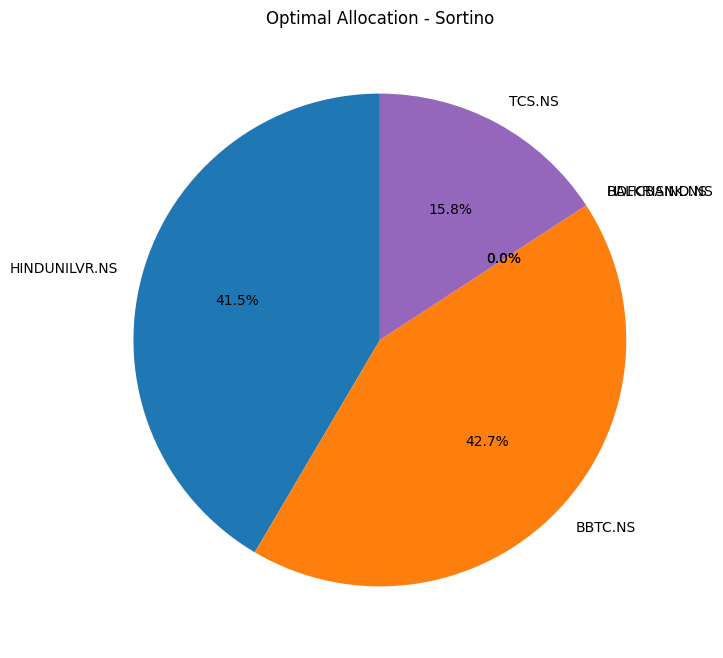
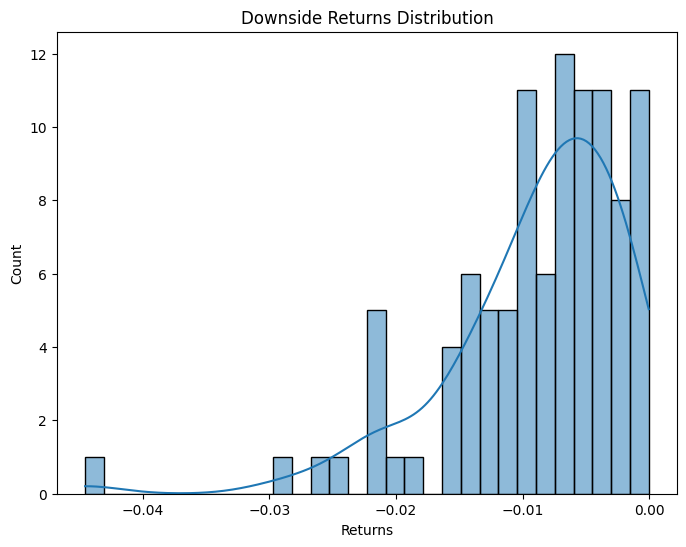
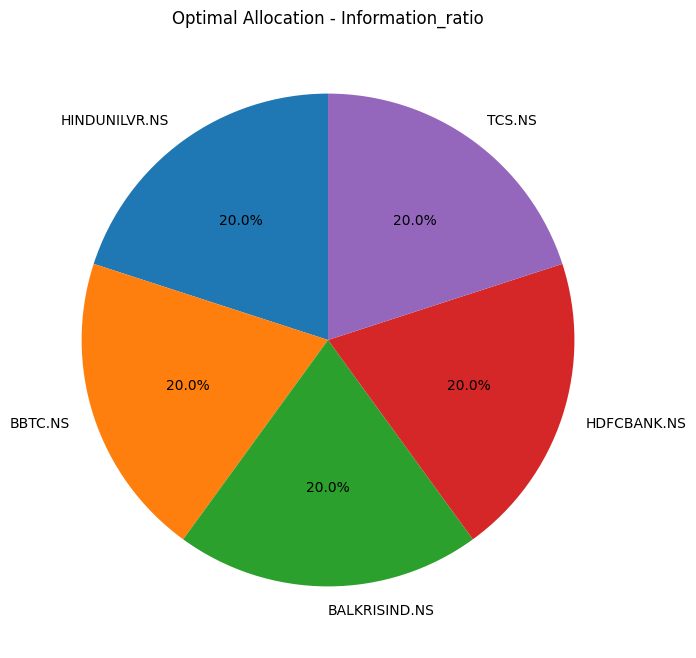
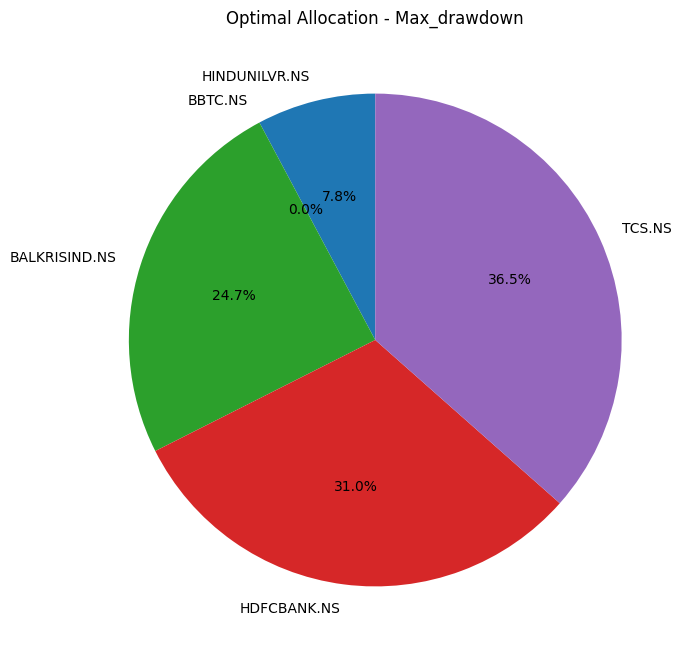
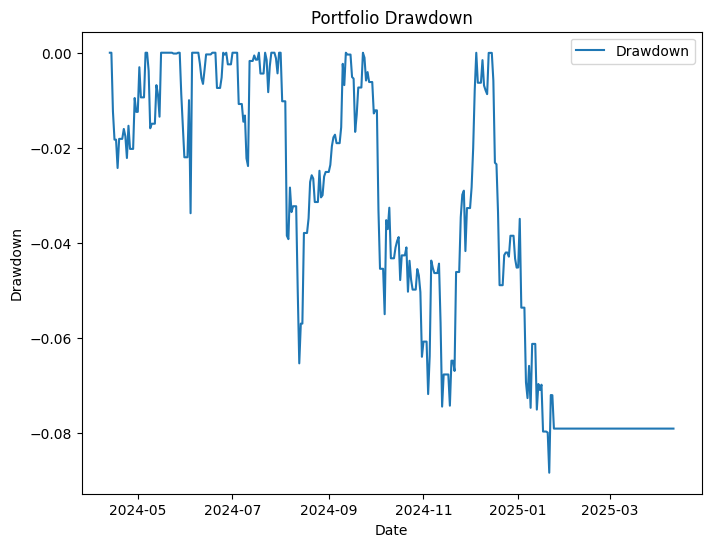
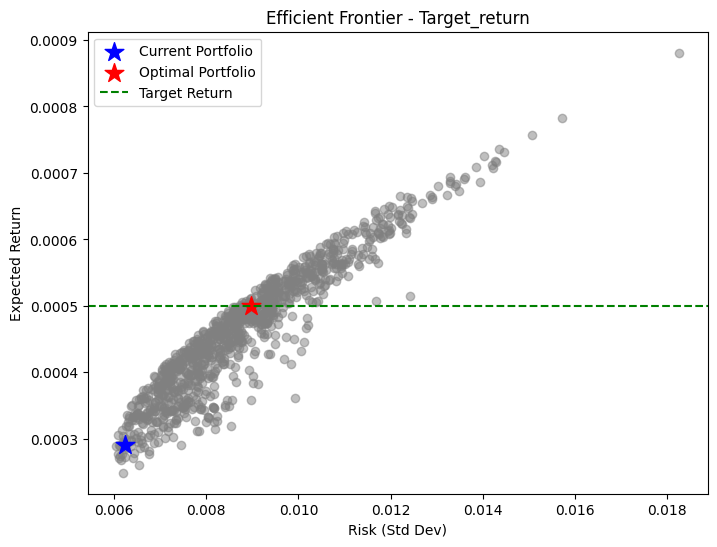
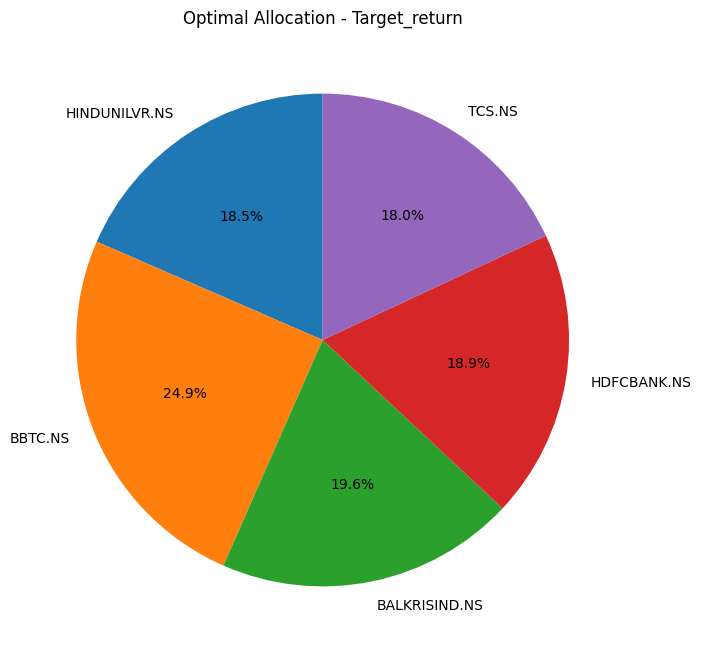
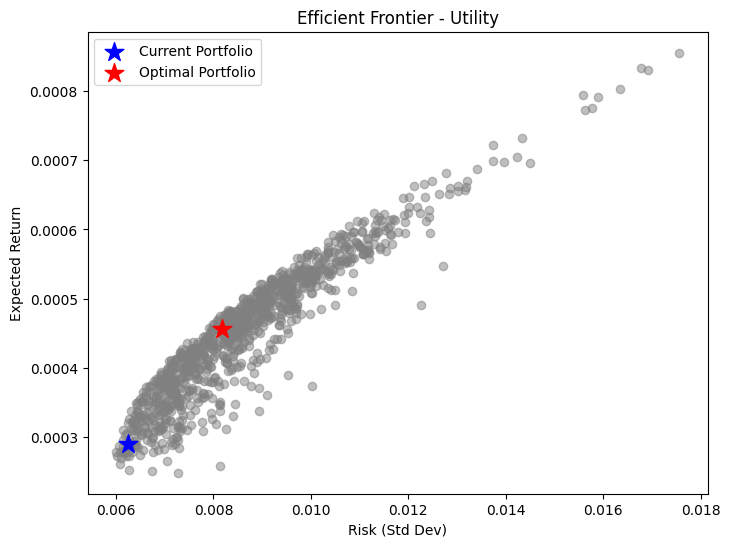
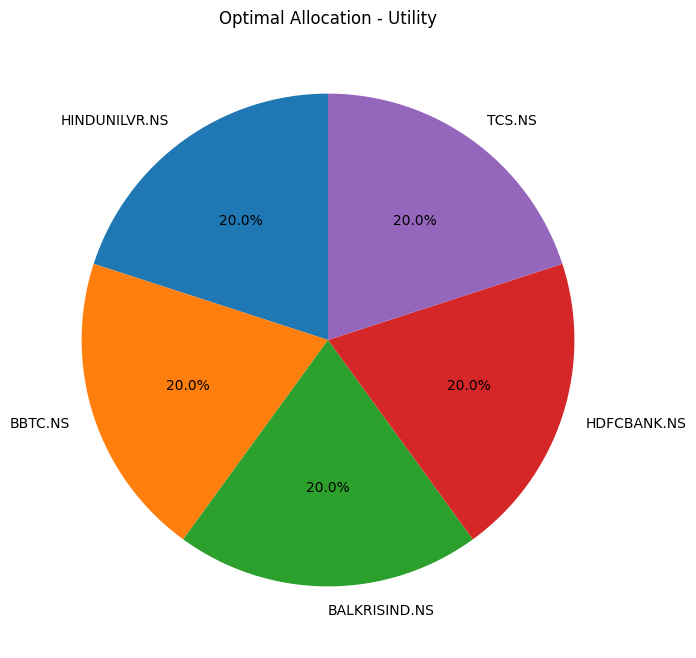
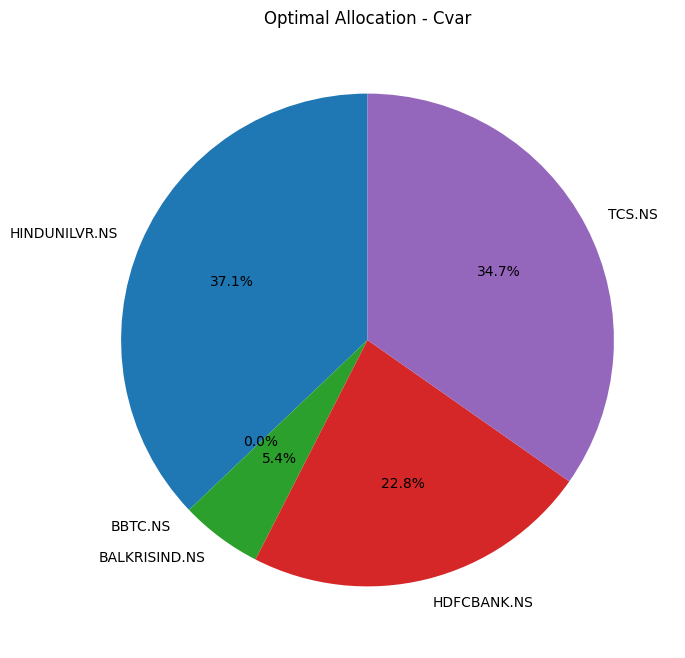
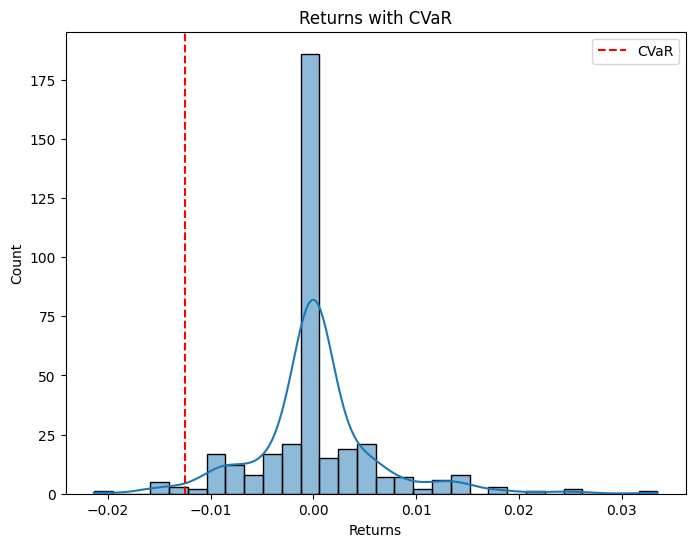
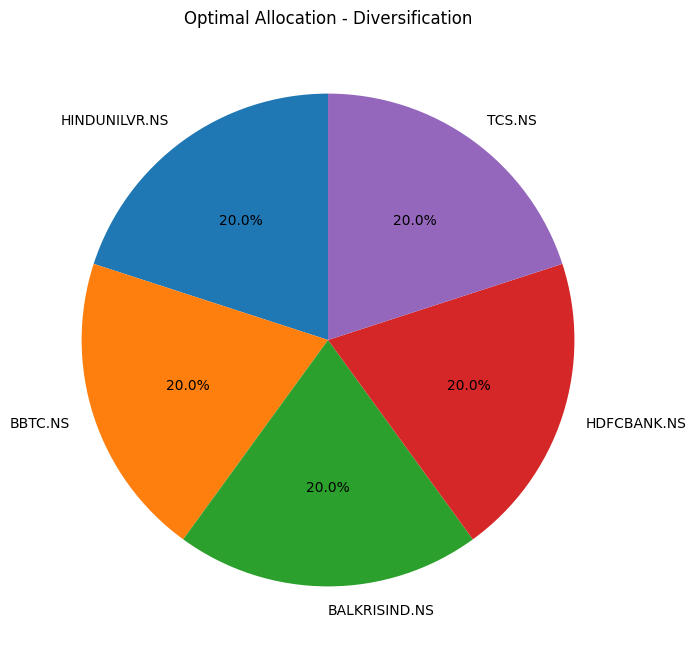

In [10]:
output["optimizations"]

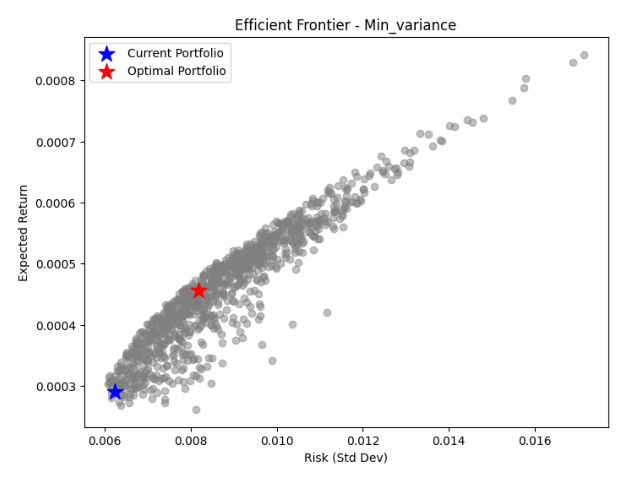

In [11]:
# Select the visualization
base64_string = output["optimizations"]["min_variance"]["visualizations"]["efficient_frontier"]

# Extract the base64 data (remove "data:image/png;base64," prefix)
base64_data = base64_string.split(',')[1]

# Decode base64 to bytes
img_bytes = base64.b64decode(base64_data)

# Load bytes into an image
img = plt.imread(BytesIO(img_bytes), format='png')

# Display using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

{'optimal_weights': {'HINDUNILVR.NS': np.float64(0.2),
  'BBTC.NS': np.float64(0.2),
  'BALKRISIND.NS': np.float64(0.2),
  'HDFCBANK.NS': np.float64(0.2),
  'TCS.NS': np.float64(0.2)},
 'suggested_investment': {'HINDUNILVR.NS': np.float64(20000.0),
  'BBTC.NS': np.float64(20000.0),
  'BALKRISIND.NS': np.float64(20000.0),
  'HDFCBANK.NS': np.float64(20000.0),
  'TCS.NS': np.float64(20000.0)},
 'current_weights': {'HINDUNILVR.NS': np.float64(0.30086627271133215),
  'BBTC.NS': np.float64(0.015259720562987697),
  'BALKRISIND.NS': np.float64(0.18720058764595757),
  'HDFCBANK.NS': np.float64(0.23289611969300575),
  'TCS.NS': np.float64(0.26377729938671685)},
 'expected_return': np.float64(0.00045668227340398915),
 'risk': np.float64(0.00817280191330489),
 'visualizations': {'efficient_frontier': '',
  'pie_chart': ''}}
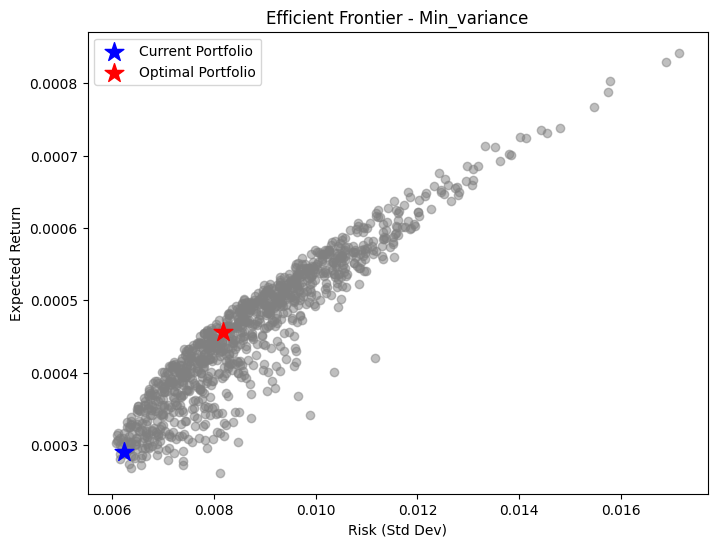
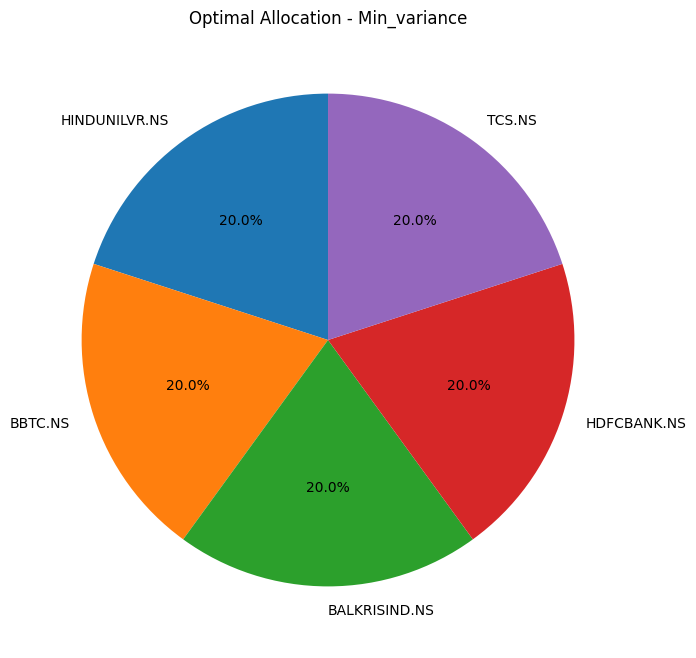

In [12]:
output["optimizations"]["min_variance"]